In [42]:
import h5py
import healpy as hp
import numpy as np
import os 
import yaml

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
import utils
import run_inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_likelihood_data(fn_config_inference):
    """
    Load likelihood data from a config inference file.
    
    Parameters:
    -----------
    fn_config_inference : str
        Path to the inference config YAML file
        
    Returns:
    --------
    dict : Dictionary containing:
        - log_likelihood_grid: 2D array of log likelihood values
        - H0_grid: 1D array of H0 values
        - alpha_agn_grid: 1D array of alpha_agn values
        - truth_H0: True H0 value from config
        - truth_alpha_agn: True alpha_agn value computed from config
        - config_inference: The loaded inference config dict
        - config_data: The loaded data config dict
    """
    print(fn_config_inference)
    
    with open(fn_config_inference, 'r') as f:
        config_inference = yaml.safe_load(f)
    
    config_data_path = config_inference['fn_config_data']
    print(config_data_path)
    
    with open(config_data_path, 'r') as f:
        config_data = yaml.safe_load(f)
    
    # Get output file from config
    fn_inf = config_inference['paths']['fn_inf']
    
    print(f"Loading likelihood grid from: {fn_inf}")
    
    # Load likelihood grid
    likelihood_results = run_inference.load_likelihood_grid(fn_inf)
    
    # Extract data
    log_likelihood_grid = likelihood_results['log_likelihood_grid']
    H0_grid = likelihood_results['H0_grid']
    alpha_agn_grid = likelihood_results['alpha_agn_grid']
    
    print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
    print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
    print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")
    
    # Get truth values from config
    truth_H0 = config_data['cosmology']['H0']
    truth_f_agn = config_data['gw_injection']['f_agn']
    truth_lambda_agn = config_data['gw_injection']['lambda_agn']
    
    with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
        N_gal_truth = f.attrs['n_gal']
        N_agn_truth = f.attrs['n_agn']
    
    _, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)
    
    return {
        'log_likelihood_grid': log_likelihood_grid,
        'H0_grid': H0_grid,
        'alpha_agn_grid': alpha_agn_grid,
        'truth_H0': truth_H0,
        'truth_alpha_agn': truth_alpha_agn,
        'config_inference': config_inference,
        'config_data': config_data
    }

In [ ]:
def plot_likelihood_data(likelihood_data, figsize=(7, 6)):
    """
    Plot likelihood data as a contour plot.
    
    Parameters:
    -----------
    likelihood_data : dict
        Dictionary returned by get_likelihood_data()
    transpose : bool, optional
        Whether to transpose the likelihood grid before plotting (default: False)
    use_log : bool, optional
        If True, plot log_likelihood_grid directly; if False, convert to normalized likelihood (default: False)
    figsize : tuple, optional
        Figure size (default: (7, 6))
    """
    log_likelihood_grid = likelihood_data['log_likelihood_grid']
    H0_grid = likelihood_data['H0_grid']
    alpha_agn_grid = likelihood_data['alpha_agn_grid']
    truth_H0 = likelihood_data['truth_H0']
    truth_alpha_agn = likelihood_data['truth_alpha_agn']
    
    # Create meshgrid for plotting
    H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)
    
    # Plot likelihood grid as contour plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert to likelihood (relative, normalized) or use log directly
    likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))
    
    # Apply transpose for plotting
    likelihood_grid = likelihood_grid.T
    
    # Fill contours
    im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
    plt.colorbar(im, ax=ax, label='Relative Likelihood')
    
    # Add green truth lines
    ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
    ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')
    
    ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
    ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
    ax.set_title(f'Likelihood Grid', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5.yaml
Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.h5
Loaded likelihood grid with shape: (20, 20)
H0 grid: 20 points from 50.0 to 100.0
alpha_agn grid: 20 points from 0.000 to 1.000


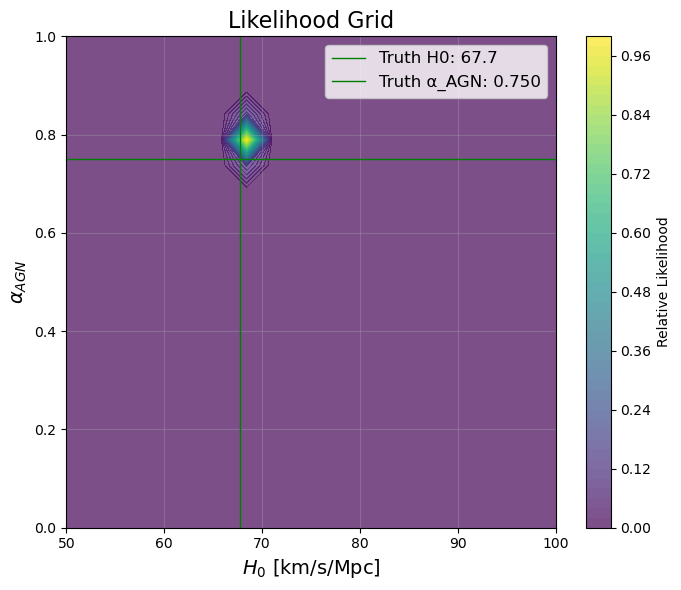

In [48]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH020_nalphaagn20_noshuffle.yaml'
likelihood_data = get_likelihood_data(fn_config_inference)
plot_likelihood_data(likelihood_data)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0.yaml
Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


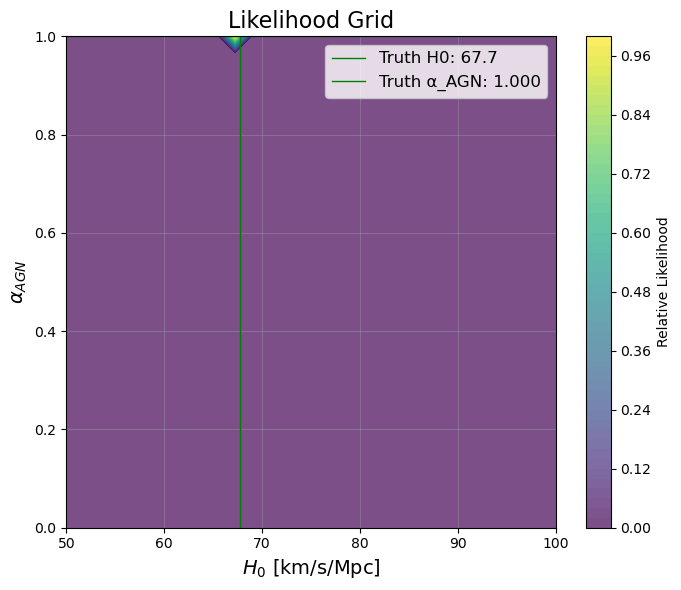

In [45]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
likelihood_data = get_likelihood_data(fn_config_inference)
plot_likelihood_data(likelihood_data, transpose=True)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml
Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


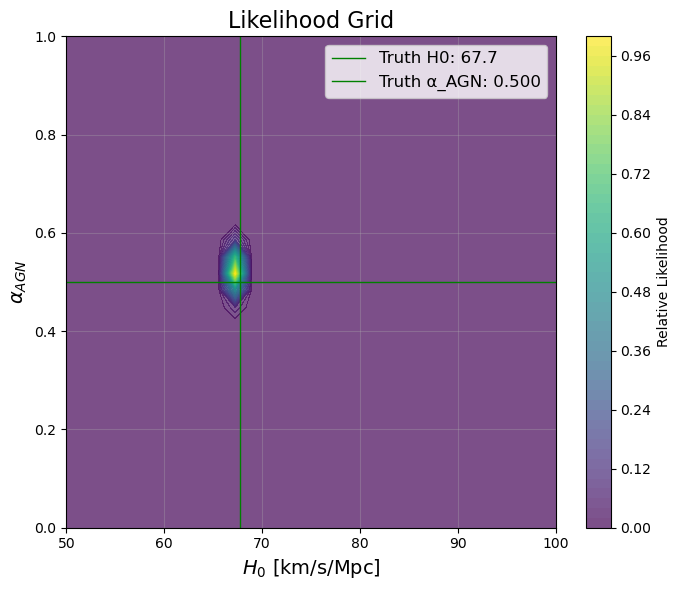

In [49]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
likelihood_data = get_likelihood_data(fn_config_inference)
plot_likelihood_data(likelihood_data)